# Fastai BW data augmentation

> Experimenting with Fastai and BW data augmentation.

In [ ]:
import pandas as pd
from pathlib import Path
import fastcore.all as fc

from fastai.data.all import *
from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ossl_source = '../../_data/ossl-tfm/ossl-tfm.csv'
df = pd.read_csv(ossl_source); df.head()

,fname,kex
0,3998362dd2659e2252cd7f38b43c9b1f.png,0.182895
1,2bab4dbbac073b8648475ad50d40eb95.png,0.082741
2,29213d2193232be8867d85dec463ec00.png,0.089915
3,8b1ee9146c026faee20a40df86736864.png,0.135030
4,6e8e9d1105e7da7055555cb5d310df5f.png,0.270421


In [ ]:
df['kex'].min(), df['kex'].max() 

(0.0, 3.6521352871126975)

In [ ]:
# image size is 750x281

In [ ]:
# ossl_source = '../../_data/ossl-tfm/ossl-tfm.csv'
# df = pd.read_csv(ossl_source); df.head()

# ossl = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                 get_x=ColReader(0, pref='../../_data/ossl-tfm/img/'),
#                 get_y=ColReader(1),
#                 batch_tfms=Normalize.from_stats(*imagenet_stats),
#                 item_tfms=RatioResize(224),
#                 splitter=RandomSplitter(valid_pct=0.1, seed=41)
                
# dls = ossl.dataloaders(df)

# learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score())
# learn.fit_one_cycle(20, 2e-3)

In [ ]:
torch.linspace(start=1, end=99.5, steps=198)


tensor([ 1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,  4.0000,  4.5000,
         5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,  8.0000,  8.5000,
         9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000, 12.0000, 12.5000,
        13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000, 16.0000, 16.5000,
        17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000, 20.0000, 20.5000,
        21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000, 24.0000, 24.5000,
        25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000, 28.0000, 28.5000,
        29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000, 32.0000, 32.5000,
        33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000, 36.0000, 36.5000,
        37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000, 40.0000, 40.5000,
        41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000, 44.0000, 44.5000,
        45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000, 48.0000, 48.5000,
        49.0000, 49.5000, 50.0000, 50.50

In [ ]:
torch.arange(1, 99.5, 1, dtype=torch.float32)


tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
        57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
        71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84.,
        85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97., 98.,
        99.])

In [ ]:
test

tensor([0.])

In [ ]:
?torch.linspace

Docstring:
linspace(start, end, steps, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Creates a one-dimensional tensor of size :attr:`steps` whose values are evenly
spaced from :attr:`start` to :attr:`end`, inclusive. That is, the value are:

.. math::
    (\text{start},
    \text{start} + \frac{\text{end} - \text{start}}{\text{steps} - 1},
    \ldots,
    \text{start} + (\text{steps} - 2) * \frac{\text{end} - \text{start}}{\text{steps} - 1},
    \text{end})


From PyTorch 1.11 linspace requires the steps argument. Use steps=100 to restore the previous behavior.

Args:
    start (float or Tensor): the starting value for the set of points. If `Tensor`, it must be 0-dimensional
    end (float or Tensor): the ending value for the set of points. If `Tensor`, it must be 0-dimensional
    steps (int): size of the constructed tensor

Keyword arguments:
    out (Tensor, optional): the output tensor.
    dtype (torch.dtype, optional): the data type t

In [ ]:
torch.linspace(start=40, end=99, steps=1)

tensor([40.])

In [ ]:
 torch.arange(40, 99, 1, dtype=torch.float32)

In [ ]:
percentiles = [
    torch.linspace(start=1, end=99.5, steps=100),
    torch.linspace(start=1, end=99.5, steps=10),
]

In [ ]:
np.random.randint(1, 50)

36

In [ ]:
start = np.random.uniform(1, 50); print(start)
end = np.random.uniform(90.1, 99.5); print(end)
steps = np.random.randint(5, 100); print(steps)
percentiles = torch.linspace(start=start, end=end, steps=steps)
percentiles

14.519014624814682
92.38541968901012
33


tensor([14.5190, 16.9523, 19.3857, 21.8190, 24.2523, 26.6856, 29.1190, 31.5523,
        33.9856, 36.4189, 38.8523, 41.2856, 43.7189, 46.1522, 48.5856, 51.0189,
        53.4522, 55.8855, 58.3189, 60.7522, 63.1855, 65.6188, 68.0522, 70.4855,
        72.9188, 75.3521, 77.7855, 80.2188, 82.6521, 85.0854, 87.5188, 89.9521,
        92.3854])

In [ ]:
percentiles_valid = []
for i in range(10):
    start = np.random.uniform(1, 50)
    end = np.random.uniform(90.1, 99.5)
    steps = np.random.randint(5, 100)
    percentiles_valid.append(torch.linspace(start=start, end=end, steps=steps))

In [ ]:
percentiles_valid

[tensor([38.4946, 40.4621, 42.4295, 44.3969, 46.3644, 48.3318, 50.2992, 52.2667,
         54.2341, 56.2015, 58.1690, 60.1364, 62.1038, 64.0713, 66.0387, 68.0061,
         69.9735, 71.9410, 73.9084, 75.8758, 77.8433, 79.8107, 81.7781, 83.7456,
         85.7130, 87.6804, 89.6479, 91.6153, 93.5827]),
 tensor([34.8541, 36.2804, 37.7067, 39.1330, 40.5593, 41.9856, 43.4119, 44.8382,
         46.2644, 47.6907, 49.1170, 50.5433, 51.9696, 53.3959, 54.8222, 56.2484,
         57.6747, 59.1010, 60.5273, 61.9536, 63.3799, 64.8062, 66.2325, 67.6587,
         69.0850, 70.5113, 71.9376, 73.3639, 74.7902, 76.2165, 77.6427, 79.0690,
         80.4953, 81.9216, 83.3479, 84.7742, 86.2005, 87.6267, 89.0530, 90.4793,
         91.9056, 93.3319, 94.7582, 96.1845, 97.6108, 99.0370]),
 tensor([43.5921, 46.1981, 48.8040, 51.4099, 54.0159, 56.6218, 59.2277, 61.8336,
         64.4396, 67.0455, 69.6514, 72.2574, 74.8633, 77.4692, 80.0752, 82.6811,
         85.2870, 87.8929, 90.4989, 93.1048, 95.7107, 98.3167]),
 ten

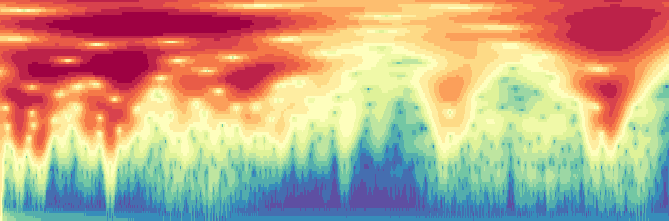

In [ ]:
@delegates()
class Quantize(DisplayedTransform):
    # split_idx,mode,mode_mask,order = None,BILINEAR,NEAREST,1
    "Quantize B&W image into `num_colors` colors."
    def __init__(self, 
        num_colors:int=10,
        verbose:bool=False,
        **kwargs
    ):
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset
    ):
        pass

    def get_random_percentiles(self):
        start = np.random.uniform(1, 50)
        end = np.random.uniform(90.1, 99.5)
        steps = np.random.randint(5, 100)
        return torch.linspace(start=start, end=end, steps=steps)

    def encodes(self, x:Image.Image):
        im_tensor = image2tensor(x)
        if self.verbose: 
            print(f'tensor shape: {im_tensor.shape} which is simply each pixel value replicated 3 times (R, G, B)')

        im_tensor = im_tensor[0, :, :]
        if self.verbose: 
            print(f'tensor shape: {im_tensor.shape}')

        # percentiles = torch.arange(40, 99, 1, dtype=torch.float32)
        percentiles = self.get_random_percentiles()
        if self.verbose: 
            print(f'percentiles: {percentiles}')

        levels = torch.quantile(im_tensor.float(), percentiles / 100)
        if self.verbose: 
            print(f'levels: {levels}')

        im_quant = torch.bucketize(im_tensor.float(), levels)
        if self.verbose: 
            print(f'im_quant: {im_quant}, # unique values: {im_quant.unique()}')

        # Color map: takes values between 0 and 1 and returns a color (RGBA)
        cmap = plt.get_cmap('Spectral_r')

        im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
        if self.verbose: 
            print(f'im_color shape: {im_color.shape}')

        im_color = im_color.permute(2, 0, 1)
        if self.verbose: 
            print(f'im_color permuted to (C, H, W): {im_color.shape}')

        im_color_fastai = to_image(im_color)
        if self.verbose: 
            print(f'im_color_fastai: {im_color_fastai}')
        return im_color_fastai
        
# Image.Image
im_path = '../../_data/all-grey-255.png'
im = PILImage.create(im_path)
# type(im)
# im = Image.open(im_path)
# PILImageBW
# fastai_im = PILImageBW(im_path) # fastai.vision.core.PILImage
# fastai_im.show(figsize=(10,10))

im = Quantize(verbose=False)(im)
im


original shape: (221, 669)
tensor shape: torch.Size([3, 221, 669]) which is simply each pixel value replicated 3 times (R, G, B)
tensor shape: torch.Size([221, 669])
percentiles: tensor([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
        68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
        82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
        96., 97., 98.])
levels: tensor([182., 183., 185., 187., 189., 191., 192., 194., 195., 198., 200., 202.,
        204., 206., 207., 209., 210., 211., 213., 214., 215., 216., 217., 218.,
        219., 220., 220., 221., 222., 223., 224., 225., 226., 227., 229., 230.,
        231., 232., 232., 233., 234., 235., 236., 237., 238., 238., 239., 240.,
        240., 241., 241., 242., 243., 243., 243., 245., 246., 248., 250.])
im_quant: tensor([[41, 41, 41,  ..., 46, 46, 46],
        [41, 41, 41,  ..., 46, 4

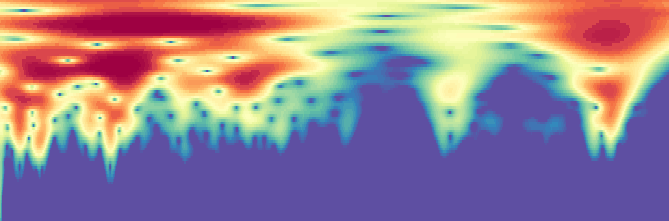

In [ ]:
im_path = '../../_data/all-grey-255.png'
im = PILImage.create(im_path)
print(f'original shape: {im.shape}')

im_tensor = image2tensor(im)
print(f'tensor shape: {im_tensor.shape} which is simply each pixel value replicated 3 times (R, G, B)')

im_tensor = im_tensor[0, :, :]
print(f'tensor shape: {im_tensor.shape}')

percentiles = torch.arange(40, 99, 1, dtype=torch.float32)
print(f'percentiles: {percentiles}')

levels = torch.quantile(im_tensor.float(), percentiles / 100)
print(f'levels: {levels}')

im_quant = torch.bucketize(im_tensor.float(), levels)
print(f'im_quant: {im_quant}, # unique values: {im_quant.unique()}')

# Color map: takes values between 0 and 1 and returns a color (RGBA)
cmap = plt.get_cmap('Spectral_r')

im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
print(f'im_color shape: {im_color.shape}')
im_color = im_color.permute(2, 0, 1)
print(f'im_color permuted to (C, H, W): {im_color.shape}')
im_color_fastai = to_image(im_color)
print(f'im_color_fastai: {im_color_fastai}')
im_color_fastai

In [ ]:
ossl = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader(0, pref='../../_data/ossl-tfm/im-bw/'),
                get_y=ColReader(1),
                batch_tfms=Normalize.from_stats(*imagenet_stats),
                item_tfms=[RatioResize(224), Quantize()],
                # item_tfms=[Quantize()],
                splitter=RandomSplitter(valid_pct=0.1, seed=41)
#    batch_tfms=aug_transforms()
)

In [ ]:
# ossl.summary(df)

In [ ]:
dls = ossl.dataloaders(df)

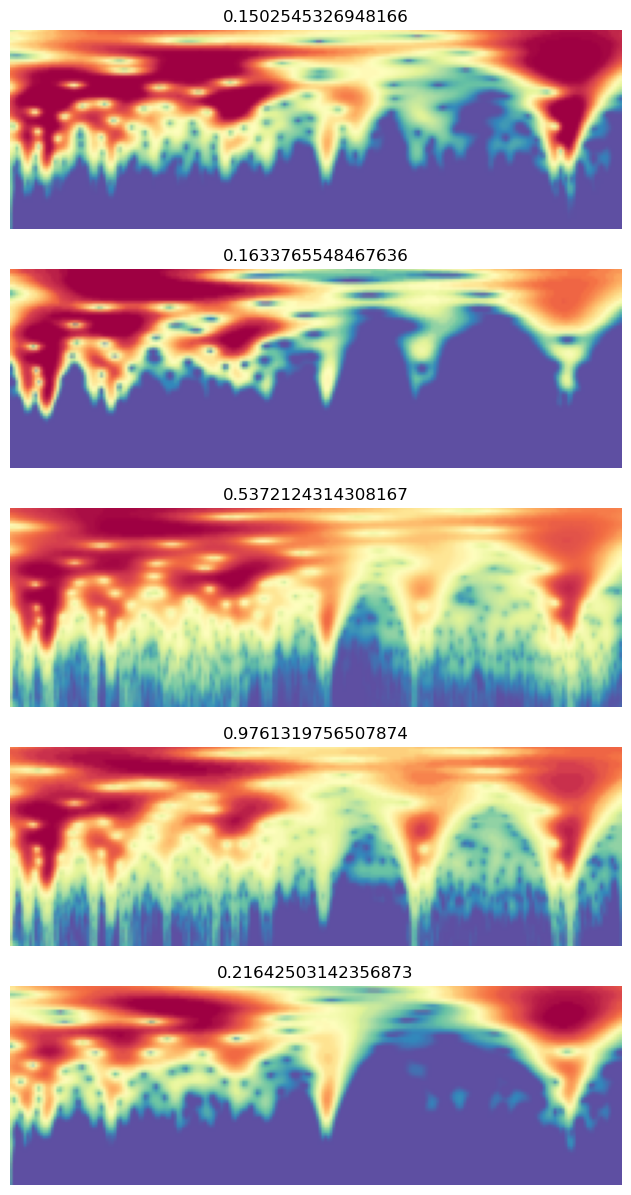

In [ ]:
dls.show_batch(nrows=5, ncols=1, figsize=(10, 15))

In [ ]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score())

SuggestedLRs(valley=0.00363078061491251)

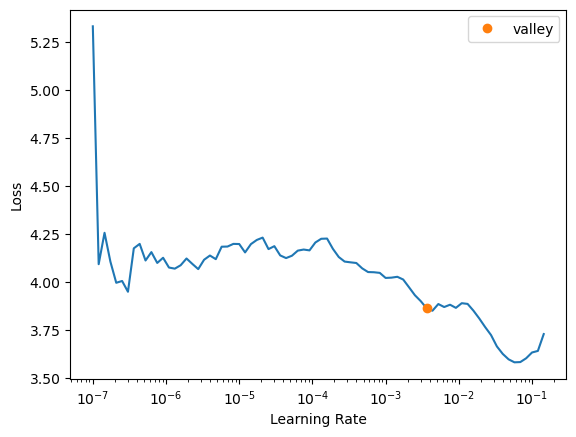

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,r2_score,time
0,1.010429,0.160208,-0.149856,07:33
1,0.101805,0.105252,0.244579,07:37
2,0.080996,0.092230,0.338037,07:45
3,0.061543,0.068272,0.509990,07:48
4,0.061344,0.045711,0.671919,07:57
5,0.055588,0.044312,0.681960,08:00
6,0.047412,0.038732,0.722007,08:06
7,0.042374,0.045522,0.673274,08:08
8,0.037796,0.034118,0.755128,08:07
9,0.030448,0.033509,0.759500,08:13


## Evaluation

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)


In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
# Convert predictions and targets to numpy arrays
# val_preds = val_preds.numpy().flatten()
# val_targets = val_targets.numpy()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds,
    'Actual': val_targets
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets, val_preds)
print(f"R2 Score on validation set: {r2:.4f}")

   Predicted    Actual
0   0.153120  0.000000
1   0.189220  0.184960
2   0.325809  0.194201
3   0.442900  0.262364
4   0.335543  0.355799
R2 Score on validation set: 0.8270


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.165464  0.00000
1   0.208306  0.20317
2   0.385151  0.21434
3   0.557217  0.30000
4   0.398699  0.42732
R2 Score on validation set (after transformation): 0.6978
Mean Absolute Percentage Error (MAPE) on validation set: 47.85%
Mean Absolute Error (MAE) on validation set: 0.1948


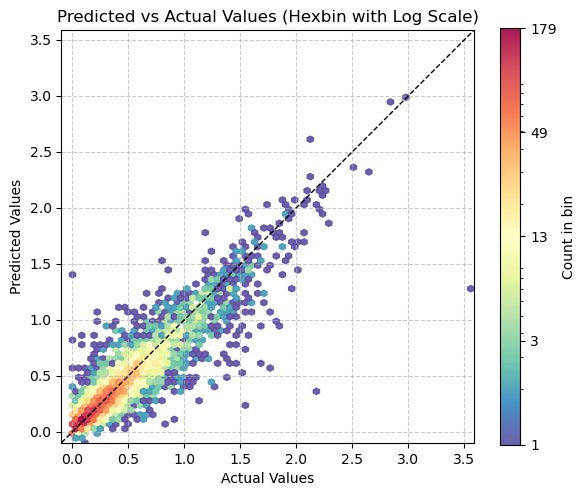

Min non-zero count in hexbins: 1.0
Max count in hexbins: 180.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379


In [ ]:
np.exp(3) - 1

19.085536923187668

## Experiments:


Color scale: `viridis` | Discretization: `percentiles = [i for i in range(60, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks |
|-----------|------------|----------------|--------|----------|----------------|------------|----------------|
| ResNet-18 | 100        | 1e-3           | 10     | 0.648    | 05:12          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     | 0.69     | 07:30          | No        | Yes             |
| ResNet-18 | 750 (original size)        |    1e-3        | 10     | 0.71          | 36:00          | No         | Yes             |
| ResNet-18 | 224        | 2e-3           | 20     |   0.704   | 07:30          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     |   0.71   | 07:00          | No        | No             |
    

Discretization: `percentiles = [i for i in range(20, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | No              | `viridis`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.71      | 05:12          | No         | No              | `jet`        |

From now on `with axis ticks` is always `No`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.71      | 05:12          | No         | None              | `jet`    |
| ResNet-18 | 224        | 2e-3         | 10     | 0.685      | 05:12          | No         | y range added              | `jet`    |


From now on random splitter with `10%` validation and random seed `41`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | Pre-train & normalize: True              | `jet`    |
| ResNet-18 | 224        | 2e-3          | 10     | 0.796     | 08:12          | No         | No Pre-train              | `jet`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.7     | 05:12          | No         | Pre-train & normalize: False            | `jet`    |
| ResNet-18 (id=0)| 224        | 2e-3          | 20     | **0.829**     | 08:12          | No         | No Pre-train (try 18 epochs)              | `jet`    |
